## Rotation Prediction

**Student: Lucas Versini**

In [1], authors propose to predict the geometric transformation applied to the entire image

<center width="100%"><img src="https://miro.medium.com/v2/resize:fit:908/1*enAk96Zn6andqoBetBy5Jg.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

They propose to use rotations by 0, 90, 180, 270 degrees as trasformations.

[1] S. Gidaris et al. “Unsupervised Representation Learning by Predicting Image Rotations”. In: ICLR. 2018.

Let's load all libraries, we will use pytorch and pytorch vision, and check whether we are using CPU or GPU

In [1]:
import os

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

## Torchvision
from torchvision import transforms
from torchvision.datasets import STL10
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

## Plot Options
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
  plt.set_cmap("cividis")
  %matplotlib inline
except:
  IN_COLAB = False

Hfactory=False # put equal to True, if you are using HFactory
if Hfactory:
    !pip install gdown==4.6.0 # with the following versions, there is an error

import gdown

Number of workers: 16


In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.backends.cuda.is_built():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1
CUDA device found.


As Dataset, we will use the STL-10 dataset (https://cs.stanford.edu/~acoates/stl10/).
It is an image recognition dataset for developing self-supervised and unsupervised feature learning, deep learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided.

Overview of the dataset:
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 5000 training images (10 pre-defined folds), 8000 test images.
- 100000 unlabeled images. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
- Images were acquired from labeled examples on $ImageNet$.

Pytorch proposes two practical data primitives, called DataSet and DataLoader, to handle datasets for pre-processing and training.
There are many data-sets pre-loaded, such as STL-10. For more info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In particular, we can easily compose several data-augmentations (transformations), that are automatically applied to the images of the dataset. Here we have an exemple with the transformations used in [1].

We will use these transformations in the following.

**Question**: What's the size of the images after the transformations ? We have two different transformations, one for Training and one for Testing. Why in your opinion ?

**Answer**:

- The size of the images after the transformations is $224 \times 224$. Indeed, the original size is $96 \times 96$, but both transformations resize and crop the image.

- For training, we crop some part of the image, resize this part to $224 \times 224$, and sometimes flip it horizontally. For testing, we resize the whole image to $256 \times 256$, and crop the center of the image. So basically, we add some variability to the training images, to help the model generalize better, and to reduce overfitting. For the test set however, we do not use random transformations, to make sure that the models are always evaluated on the same (deterministic) images.

In [3]:
transformTrain = transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # these are the average and std from ImageNet
         ])

transformTest = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
         ])

We will use only the training and test datasets (few images) to speed up computations.
- If you are using Google Colab, the STL10 dataset will be downloaded in `./data`. if you have already downloaded it in your Google Drive, you can mount it using the following line of code

from google.colab import drive

drive.mount('/content/drive')

and then either change the path.

- If you are running the code locally, just copy/paste the path of the folder where you have downloaded the dataset. In the code, I assume you have `stl10_binary.tar.gz` and the folder `stl10_binary` inside the `./data`folder.

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
if IN_COLAB:
    #data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory="/content/drive/MyDrive/TP/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif Hfactory:
    data_directory="./"    
else:
    data_directory="./" # copy/paste the path of the folder with STL dataset in your computer


train_dataset = STL10(root=data_directory+"data", split="train", download=True, transform=transformTrain)
test_dataset = STL10(root=data_directory+"data", split="test", download=True, transform=transformTest)

Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the training and test datasets.

In [6]:
# Train dataset
classes=train_dataset.classes
print(classes)
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image
print(train_dataset[3][1]) # this is a label

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Train dataset: 5000
torch.Size([3, 224, 224])
6
Number images in Test dataset: 8000
torch.Size([3, 224, 224])


Let's plot few images to see how are they. We need to de-normalize images using the statics of ImageNet (images come from ImageNet)

In [7]:
def imshowSTL10(dataset,rows=3,columns=3,figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, rows*columns+1):
      img = dataset[i][0]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      img = np.clip(unnormalize(img).numpy(),0,1)

      label = dataset[i][1]
      fig.add_subplot(rows, columns, i)
      plt.title(dataset.classes[label])
      plt.imshow(np.transpose(img, (1, 2, 0)), cmap='cividis')
      plt.axis("off")
    plt.show()

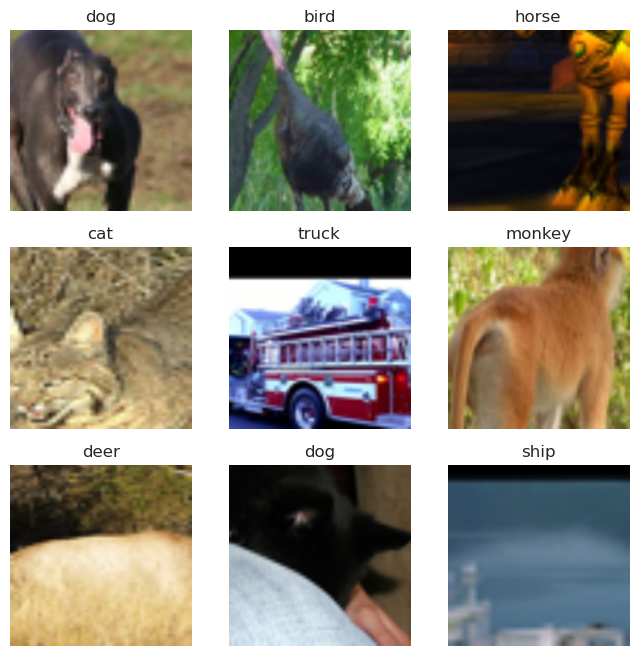

In [8]:
imshowSTL10(train_dataset)

Now it's time to implement our network.

Since STL10 comes from ImageNet, we take the same network proposed for ImageNet in [1], inspired by AlexNet.

Here you can find the (modified) version of AlexNet (e.g., no DropOut) borrowed from the GitHub of the authors.  

**Question**: Choose an approriate value for num_classes and explain why

**Answer**: In the considered task, the model needs to predict the angle, which can be 0°, 90°, 180° or 270°. There are therefore 4 possible angles, so we set `num_classes = 4`.

In [9]:
# Code borrowed from https://github.com/gidariss/FeatureLearningRotNet
# AlexNet
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        num_classes = 4
        
        conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        )
        conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        num_pool5_feats = 6 * 6 * 256
        fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_pool5_feats, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )
        classifier = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

        self._feature_blocks = nn.ModuleList([
            conv1,
            pool1,
            conv2,
            pool2,
            conv3,
            conv4,
            conv5,
            pool5,
            fc_block,
            classifier,
        ])
        self.all_feat_names = [
            'conv1',
            'pool1',
            'conv2',
            'pool2',
            'conv3',
            'conv4',
            'conv5',
            'pool5',
            'fc_block',
            'classifier',
        ]
        assert(len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):

        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1],] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')
        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.
        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.
        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat+1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats)==1 else out_feats
        return out_feats

    def get_L1filters(self):
        convlayer = self._feature_blocks[0][0]
        batchnorm = self._feature_blocks[0][1]
        filters = convlayer.weight.data
        scalars = (batchnorm.weight.data / torch.sqrt(batchnorm.running_var + 1e-05))
        filters = (filters * scalars.view(-1, 1, 1, 1).expand_as(filters)).cpu().clone()

        return filters

And here it's the most important part of the code.

We build the RotationPrediction Module.

As in [1], we use the 'conv5' layer as representation features and a small classifier, as proposed in the paper.

The key part is in the 'forward' function and in '_preprocess'.

**Question**: complete the code XXXXXX in the '_preprocess' function. Remember that we are implementing the method of [1] as shown in the figure at the beginning of this TP.

In [10]:
## Joint optimization 
class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, n_classes_classifier, device):
        super().__init__()
        self.device=device
        self.model = AlexNet().to(self.device)
        self.latent_dim = 256 * 6 * 6 # as defined in [1]
        self.feat_layer = 'conv5' # as defined in [1]
        self.n_classes_classifier = n_classes_classifier

    # Same Classifier as defined in [1]
    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((6, 6)),
            nn.BatchNorm2d(256, affine=False),
            nn.Flatten(),
            nn.Linear(self.latent_dim, self.n_classes_classifier)
        )
        classifier=classifier.to(self.device)
        return classifier

    def forward(self, images):
        images=images.to(self.device)
        batch_size = images.shape[0]

        #images must have a torch.Size([batch_size, Channels, Height, Width])
        #target must have a torch.Size([batch_size])
        images, targets = self._preprocess(images)
        targets = targets.to(self.device)

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets).to(self.device)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        zs = zs[:batch_size]
        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images, flatten=True):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs.flatten(start_dim=1)

    def _preprocess(self, images):
        batch_size = images.shape[0]
        # Remember that the rotations should be computed using only two operations...
        images_0 = images
        images_90 = torch.rot90(images_0, 1, [2, 3])
        images_180 = torch.flip(images_0, [2, 3])
        images_270 = torch.rot90(images_90, 1, [2, 3])

        # These are the Images to Predict and must have a torch.Size([batch_size, Channels, Height, Width])
        images_batch = torch.cat([images_0, images_90, images_180, images_270], dim=0)
        # Target are Labels (0,1,2,3) and must have a torch.Size([batch_size*4])
        targets = torch.cat([torch.zeros(batch_size),
                             torch.ones(batch_size),
                             2 * torch.ones(batch_size),
                             3 * torch.ones(batch_size)],
                             dim = 0).long()
        return images_batch, targets

Here we train our algorithm and evaluate its prediction power on a test set (function 'validate') using the function `accuracy`.

**Question**: Do you understand what the function accuracy compute ? Explain what the output `res` contains

**Answer**:

- `pred` contains the indices corresponding to the `maxk` classes with highest predicted probability.

- `correct` then contains 0's and 1's, corresponding to whether the above indices correspond to the groundtruth class.

- Then, for each of the classes in `topk`, `correct_k` computes the number of correct predictions, in the sense that the groundtruth class is one of the `k` classes with highest predicted probability. We then append to `res` the proportion (percentage) of correct answers.

So overall, `accuracy` returns a list `res` which contains `len(topk)` numbers, each corresponding to the score of the model using top `k` predictions (with `k` elements of `topk`).

In [11]:
def accuracy(output, target, topk=(1,)):

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True) # sliced torch.argsort (for each row, it outputs the indices containing the k max values)
        pred = pred.t() # transpose to get batches as last dimension
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # first transpose then expand target to be the same size as pred and then elementwise-equality

        # compute number of samples in the batch that has correct label in the k highest predictions
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Now we can define our train function. 


**Question**: Look at the optimization process and describe it. How do we minimize the rotation prediction module and classifier ? Could you do it differently ?

**Answer**:
The model computes `out, zs` from the images. `out` essentially contains the self-supervised loss (in `out['Loss']`), while `zs` are latent variables extracted from `conv5`.

We do not want to optimize over `zs` later when optimizing the classifier, so we set `zs = zs.detach()`. Then, we optimize the self-supervised loss.

Then, we compute the logits by using `classifier` and `zs`, compute a cross entropy loss between the output of `classifier` and the groundtruth classes, and we optimize using this classification loss.

Instead of using two separate optimizations, we could compute a loss `total_loss = a * SSL_loss + b * Entropy_loss` for some positive constants `a, b`, and optimize this loss. Therefore the models could learn features that work simultaneously for both tasks. However, `a` and `b` would need to be tuned carefully.

In [12]:
def train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device):

    model.train()
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)
        out, zs = model(images)
        zs = zs.detach() # detach from the graph,  requires_grad = False

        # compute optimizer step for ssl task using the previously defined Loss function of the model
        optimizer.zero_grad()
        out['Loss'].backward()
        optimizer.step()

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        if i % 20 == 0:
           print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

Here, we define the:
- DataLoader, a pytorch object that wraps an iterable around the Dataset to enable easy access to the samples duing training or validation
- optimization process
- the sceduler
- all hyper-parameters (max epochs, batch size, lr, weight decay,etc.)

Please note that it will lauch the training process. It can last some time... OR

you can directly load a pre-trained model in the following cell !

**Question**: what's the correct value for n_classes_classifier using the STL dataset ?

**Answer**: `n_classes_classifier` is the number of classes for the classifier's task. The STL dataset contains 10 classes, so we set `n_classes_classifier = 10`.

<span style="color:red"> **Remark**: </span> Below, we train a model for 2 epochs. We also tried for 50 epochs, and the results are given later on.

In [13]:
maxepochs=2 # maximum number of epochs
# maxepochs=50 # maximum number of epochs
bs=256 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU 
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

for epoch in range(maxepochs):
  top1Tr, top5Tr = train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)
  scheduler.step()
  scheduler_classifier.step()


Device: cuda:0
Epoch 0, Iter: 0 out of 20, Average loss: 0.0005, acc 1: 7.8125
Epoch: 0, Average loss: 0.0022, Average acc 1: 12.8803, Average acc 5: 55.8743
Epoch 1, Iter: 0 out of 20, Average loss: 0.0024, acc 1: 15.2344
Epoch: 1, Average loss: 0.0012, Average acc 1: 16.5177, Average acc 5: 61.8739


If you want to save your model, we can use torch.save

In [14]:
os.makedirs(data_directory+'models/', exist_ok=True)
# filename = 'models/checkpoint_rotation_2epochs.pth.tar'
filename = 'models/checkpoint_rotation_' + str(maxepochs) + 'epochs_trained.pth.tar'
torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'state_dict_classifier': classifier.state_dict(),
                'optimizer_classifier': optimizer_classifier.state_dict(),
                'schedular_classifier': scheduler_classifier.state_dict()
            }, data_directory+filename)

If you want, here you can download the same model as before but already pre-trained for 50 epochs.

It's important to set the 'model.eval()' since we want to evaluate it and not train it (no gradient is computed and parameters are not updated)


In [15]:
model_path = 'models/checkpoint_rotation_50epochs.pth.tar'

if os.path.isfile(data_directory+model_path):
    print("pre-trained model already downloaded")
else:
    print("downloading the pre-trained model")
    os.makedirs(data_directory+'models/', exist_ok=True)
    file_url = 'https://drive.google.com/uc?id=1ADslBKLjo1ulEfmz12ufEk2cjqnYJVRp'    
    gdown.download(file_url, data_directory+model_path)

# Number of classes
n_classes_classifier = 10 # same as before

# Load checkpoint file of already trained model
ckpt = torch.load(data_directory+model_path,map_location=torch.device(device))

# Load Model parameters and set it into eval mode
model_download = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
model_download.load_state_dict(ckpt['state_dict'])
model_download.to(device)
model_download.eval()

# Load classifier model
classifier_download = model_download.construct_classifier()
classifier_download.load_state_dict(ckpt['state_dict_classifier'])
classifier_download.to(device)
classifier_download.eval()

pre-trained model already downloaded


/tmp/ipykernel_3234357/3237304043.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(data_directory+model_path,map_location=torch.device(device))


Sequential(
  (0): AdaptiveMaxPool2d(output_size=(6, 6))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=9216, out_features=10, bias=True)
)

Now we can test our model on the test set.

**Question**: complete the code to compute average loss and average acc 1 and average acc 5 on the test set

In [16]:
def test(test_loader, model, classifier, device):
    # switch to evaluate mode
    model.eval()
    classifier.eval()
    top1=[]
    top5=[]
    average_loss = 0
    num_samples = 0

    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            _, zs = model(images) # We do not use out['Loss'] and out['Acc1'] here
            logits = classifier(zs)
            loss = F.cross_entropy(logits, target)

            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.append(acc1[0])
            top5.append(acc5[0])

            average_loss += loss
            num_samples += target.shape[0]

    average_loss /= num_samples
    average_acc1 = sum(top1) / len(top1)
    average_acc5 = sum(top5) / len(top5)
    average_loss, average_acc1, average_acc5 = average_loss.item(), average_acc1.item(), average_acc5.item()
           
    return average_loss, average_acc1, average_acc5

In [17]:
bs=128 # batch size

# when testing is better to use drop_laste=False to use the entire test set. Otherwise, pytorch divides the dataset into batches and ignores the last batch if it does not reach the requested batch_size (thus when the number of samples is not divisible by the batch size)
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)

# Choose either the model trained here or the downloaded model
model_test=model
# model_test=model_download

classifier_test=classifier
#classifier_test=classifier_download

AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [18]:
print(f"Average Loss: {AvgLoss:.4f}, Average Top-1 Accuracy: {top1Te:.2f}, Average Top-5 Accuracy: {top5Te:.2f}")

Average Loss: 0.0407, Average Top-1 Accuracy: 20.77, Average Top-5 Accuracy: 65.94


**Question**: are you satisfied with the obtained result ? If you had more time, what would you do to improve the results ?

**Answer**: We show the results below. We also trained a model on 50 epochs to compare it to the downloaded one.

Model | Average Loss | Average top-1 Accuracy | Average top-5 Accuracy
--- | --- | --- | ---
2 epochs | 0.042 | 19.69 | 70.31
50 epochs | 0.011 | 54.13 | 95.09 

We see that there is a large difference between the model we trained for 2 epochs and the one we trained for 50 epochs. The one trained for 50 epochs reaches a top-1 accuracy of about 54 %. This is not bad (a random model would reach 10 %), but still a bit disappointing. The top-5 accuracy is about 95 %. So 95% of the time, the groundtruth class is among the 5 classes with highest predicted probability.

(Remark: when using the downloaded model, the results are random. Maybe there is a difference in implementation...)

With more time, we could:
- See if training the model for even more epochs improves the results
- Use more sophisticated data augmentation
- Fine-tune the hyperparameters (batch size, learning rate, etc.)
- Use pretrained weights (on ImageNet for instance)
- Use other models
- Change the self-supervised task
- Etc.

**Question**: If you look carefully at the RotationPrediction module, you can see that we optimize the rotation prediction module and the small classifier using *different* optimizers but within the same training. You could also train them separately: first train the rotation prediction module, fix it, and then train the small classifier. Try it and comment the results.

**Answer**:
Below, we write a function `train_separate` which is very similar to `train`, except that the optimizers can be equal to `None`, in which case the corresponding model is not trained.

For 50 epochs, we observe that the obtained accuracies are 59.08 % (top 1) and 95.99 % (top 5), which is a bit better than previously.

We can try and interpret this:
- The feature extractor learns features without being disturbed by the classifier at the beginning. Moreover, this may avoid overfitting on the labels
- The training of the classifier is more "stable", because the embeddings are frozen. Moreover, this training is "easier", because the features are already relevant from the start.

However, this takes much longer than before.

It was not obvious that the results would be better: indeed, the features learned via rotation prediction may not be suited for the classification task. Joint optimization helps learn features that are useful for the self-supervised task, but also for the classification. The ones learned only during the self-supervised task could contain only a little bit of information.

In [19]:
def train_separate(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device, verbose = False):
    if optimizer is not None:
        model.train()
        model.requires_grad_(True)
    else:
        model.eval()
        model.requires_grad_(False)

    if optimizer_classifier is not None:
        classifier.train()
        classifier.requires_grad_(True)
    else:
        classifier.eval()
        classifier.requires_grad_(False)

    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        images = images.to(device)
        target = target.to(device)
        out, zs = model(images)
        zs = zs.detach() # detach from the graph,  requires_grad = False

        # compute optimizer step for ssl task using the previously defined Loss function of the model
        if optimizer is not None:
            optimizer.zero_grad()
            out['Loss'].backward()
            optimizer.step()

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        if optimizer_classifier is not None:
            optimizer_classifier.zero_grad()
            loss.backward()
            optimizer_classifier.step()

    if verbose and optimizer_classifier is not None:
        print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))

In [20]:
# model_download.to("cpu")
# classifier_download.to("cpu")
del model_download
del classifier_download
torch.cuda.empty_cache()

maxepochs=2 # maximum number of epochs
bs=256 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU 
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

print("\nTraining the model\n")
for epoch in range(maxepochs):
  train_separate(train_loader, model, classifier, optimizer, None, epoch, device)
  scheduler.step()
  if epoch % 10 == 0:
    print(f"Epoch {epoch} finished")

torch.cuda.empty_cache()

print("\nTraining the classifier")
for epoch in range(maxepochs):
  train_separate(train_loader, model, classifier, None, optimizer_classifier, epoch, device, verbose = True)
  scheduler_classifier.step()
  if epoch % 10 == 0:
    print(f"Epoch {epoch} finished")

# Test

bs=128
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)
model_test=model
classifier_test=classifier
AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

print(f"\nAverage Loss: {AvgLoss:.4f}, Average Top-1 Accuracy: {top1Te:.2f}, Average Top-5 Accuracy: {top5Te:.2f}")


Device: cuda:0

Training the model

Epoch 0 finished

Training the classifier
Epoch: 0, Average loss: 0.0030, Average acc 1: 13.4306, Average acc 5: 57.4586
Epoch 0 finished
Epoch: 1, Average loss: 0.0011, Average acc 1: 16.9841, Average acc 5: 62.5574
Average Loss: 0.0392, Average Top-1 Accuracy: 19.52, Average Top-5 Accuracy: 67.11
